<h1> Thursday Harbor: SciPy Tutorial </h1>

In [1]:
# import statements
import scipy
import scipy.signal as signal
import scipy.ndimage as ndi
import scipy.stats as stats
import scipy.optimize as optimize

from PIL import Image

In [2]:
# import statements
import numpy as np
import pandas as pd
import h5py
import skimage.feature

In [3]:
import matplotlib.pyplot as plt
%pylab inline 
pylab.rcParams['figure.figsize'] = (9, 6)

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os
for f in ['MAX_ZSeries-ch1.tif', 'MAX_ZSeries-ch2.tif', 
          'power_calibrations.csv', 'sweeps.h5', 'BOb.png']:
    if not os.path.isfile(f):
        print 'please download %s' %(f)

<h2> Outline </h2>

1. Curve fitting and optimization using scipy.optimize
2. Signal Processing and 1D Filtering using scipy.signal
4. 2D (image) loading and filtering using scipy.ndimage and scipy.signal
4. Some statistics using scipy.stats
5. Optional material/exercise (time permitting)

Note that during all of these modules, there will be examples of various ways to load/save and visualize data

<h2> Curve Fitting & Optimization </h2>

Many of the functions we are interested in are nonlinear. A nonlinear least squares fit is an iterative process to minimize the error function (residuals) of the fit to the data provided. This is why a nonlinear least squares fit, unlike a regression, needs an initial guess for the parameters to be optimized. 

Let's start with a simple curve: we will attempt to find an analytic equation for the conversion of a laser output voltage to a mW/area power value by fitting a sigmoid to measured data. The data are saved as columns in a .csv file. The Pandas library allows us to quickly load this data and retain its tabular format. 

In [5]:
#load up the data file here
power_calib_file = 'power_calibrations.csv'
power_df = pd.read_csv(power_calib_file)
power_df.head()

,PockelVoltage,Pockel,FidelityPower,BeamDiamter(um),FidelityPowerPerArea
0,0.000000,0,0.0,1.2932,0.000000
1,0.018939,1,0.1,1.2932,0.076173
2,0.037879,2,0.1,1.2932,0.076173
3,0.056818,3,0.2,1.2932,0.152345
4,0.075758,4,0.4,1.2932,0.304691


The Pandas library also contains some "smart" (and quick) plotting functions, where we can tell the plot function which column of the dataframe we want on each axis. 

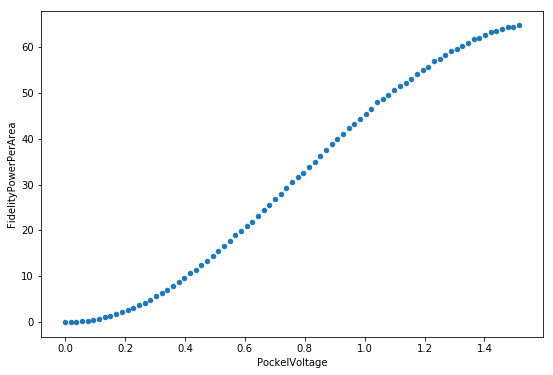

In [6]:
power_df.plot(x='PockelVoltage', y='FidelityPowerPerArea', kind='scatter')

I've written two important functions here: `sigmoid` takes as inputs an array of 4 parameters, and either a numpy array (or scalar) of input data. It returns a numpy array (or scalar) of "output" sigmoidal data according to the following:

$$
P = \frac{A}{1 + {e}^{-B*(x - C)}} + D
$$

`diff_fxn` defines the error function to be minized by SciPy's `least_squares` functions. It is simply the difference (residuals) of the measured data and sigmoidal function. Note that we can pass the `sigmoid` function into `diff_fxn` as a parameter (`fxn` in this case). This would be useful if we wanted to write several functions describing different fits, and test how well they described our data with a single error function. 

In [7]:
# params is a numpy array with 4 values (A, B, C, D); each value represents a constant used to determine the sigmoid
# x is the input array

def sigmoid(params, x):
    A, B, C, D = params[0], params[1], params[2], params[3]
    fx = A / (np.exp(-B*(x-C)) + 1) + D
    return fx

def diff_fxn(params, fxn, x, data):
    return data - fxn(params, x) #note, that if fxn=sigmoid, fxn(params, x) = sigmoid(params, x)


p0 = np.array([10, -10, 1, 20]) # initial guess

voltage_input = power_df.PockelVoltage.values # input to the fitting function
measured_power = power_df.FidelityPowerPerArea.values # real data used to find fit

SciPy's `optimize.least_squares` function takes two required inputs -- the error function and the initial parameters -- as well as any additional arguments that need to be passed into the error function in proper order [in our case, the fit function `sigmoid`, the input data (voltage_input) and the measured data (measured_power)]. 

In [8]:
fit = optimize.least_squares(diff_fxn, p0, args = (sigmoid, voltage_input, measured_power))

print fit.x

[-77.43681742  -3.38188479   0.79205091  71.12823269]


The fit parameters tell us our analytic equation should take the following form:

$$
P = \frac{-77.4}{1 + {e}^{3.38*(V - 0.79)}} + 71.1
$$

Let's qualitatively see how good the parameter estimation is by passing the fit parameters into the sigmoid function and plotting it on the same axis as our measured results. 

In [9]:
sigmoid_fit = sigmoid(fit.x, voltage_input) #pass our optimized fit parameters and input into the sigmoid function

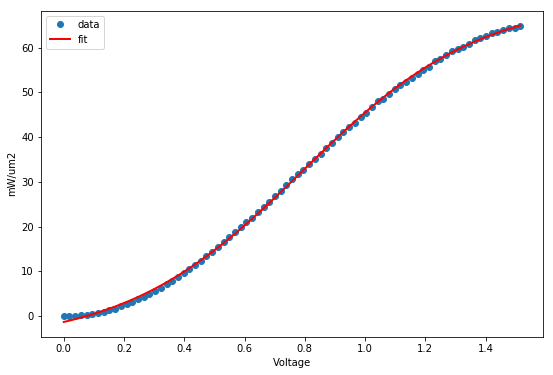

In [10]:
########### PLOTTING #############
fig = plt.figure()
ax = fig.add_subplot(111)
data = ax.plot(voltage_input, measured_power, 'o')
fit_data = ax.plot(voltage_input, sigmoid_fit, color='r', linewidth=2)
plt.legend(['data', 'fit'])
ax.set_xlabel('Voltage')
ax.set_ylabel('mW/um2')
##################################

**SOME ADDITIONAL TIPS:**

If `optimize.least_squares` is not coverging on a reasonable solution, consider adjusting your initial parameter guess. A good way to do that would be to plot several options for each parameter and qualitatively look for a reaosnable fit to your data. Pass that guess into `least_squares` and see if a minimum can be found. 

Next, `optimize.least_squares` takes some additional arguments that can give you more control over the fitting. You can set bounds to constrain the minimization region, or the minimzation method. If computation time is an issue, the Jaocbian matrix (a matrix of the partial derivatives of each component of fit) can be defined and passed into `optimize.least_squares`. 

See more here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

Additionally, `optimize.minimize` has similar functionality, with more freedom to set various bounds and methods for optimization. `optimize.curve_fit` contains a built in error function, so it is not necessary to define this, but only the fit function, when using this module.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

** EXERCISE: FIT AN EXPONENTIAL TO A PHOTOBLEACHED CALCIUM TRACE AND SUBTRACT THIS NONLINEAR BASELINE**

In [11]:
################ EXERCISE ####################
# Let's load up a noisy trace using h5py
# Note that by using "with" instead of file.open(), the file is automatically closed once we are completed

with h5py.File('noisy_signal.h5', 'r') as f:
    noisy_ca_trace = np.array(f['signal']) #path to trace

sample_rate = 30 #Hz
step_size = 1.0/sample_rate
time_vec = np.linspace(0, len(noisy_ca_trace)/sample_rate, len(noisy_ca_trace))


An exponential should take the following form:

$$
Y = A*{e}^{B*t} + D
$$

Note that your initial guess for B should be negative for a decaying exponential.

[  9.39554407e+01  -3.29614964e-03   6.16342771e+00]


C:\Users\aliceb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: overflow encountered in exp
C:\Users\aliceb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: overflow encountered in multiply


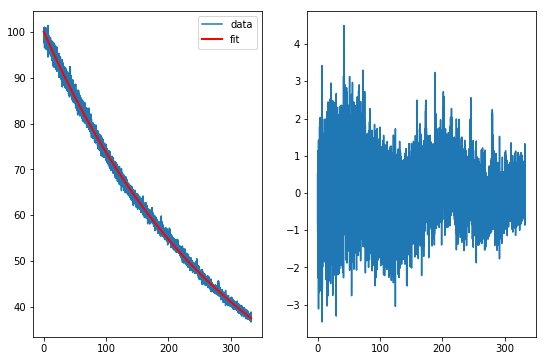

In [12]:
############### EXERCISE CONT #################
# Suggestions: 1) write a function that takes parameters and time, and returns an exponential 2) optimize your parameter guess
# 3) subtract the exponential fit from the trace 

def exponential(params, t):
    exp_fxn = params[0] * np.exp(params[1]*(t)) + params[2]
    return exp_fxn

p_guess = np.array([100.0, -300.0, 0.0])
exp_params = optimize.least_squares(diff_fxn, p_guess, args = (exponential, time_vec, noisy_ca_trace))

print exp_params.x

exp_fit = exponential(exp_params.x, time_vec)

baseline_subtracted_ca = noisy_ca_trace - exp_fit #KEEP TRACK OF THIS, WE WILL USE IT LATER

########### PLOTTING #############
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time_vec, noisy_ca_trace)
ax1.plot(time_vec, exp_fit, color='r', linewidth=2)
ax2.plot(time_vec, baseline_subtracted_ca)
ax1.legend(['data', 'fit'])
ax.set_xlabel('s')
ax.set_ylabel('dF/F')
##################################

<h2> Signal Processing </h2>

By digitally sampling a signal, we are turning a continuous signal into a discrete, finite signal, and thus introduce several limitations into how we approach extracting meaning from data. The most obvious is the sampling rate: we cannot expect to detect any periodic signal that occurs faster than half the sampling rate (Nyquist frequency) due to the potential for aliasing errors. The sampling rate thus plays a big role in the detecting frequencies in data and applying any desired filters. 

Fourier analysis is the cornerstone of DSP. It is predicated upon the theory that any signal can be written as a sum of an infinite number of cosines and sines. Applicable to signal analysis, is the ability to bring a signal into the Fourier domain, and see what frequencies are present in the signal (and at what powers). From there, we can try to figure out where to properly apply filters to attenuate any noise. 

The discrete time Fourier transform (DFT) is how we perform this analysis on a finite, sampled signal. There are some tricks to the algorithms that exist in Python (and MATLAB). First, the output is the mirror image of the positive and negative frequency components -- make sure you are looking at the right one. Second, the output has imaginary components, so take the magnitude (`abs()` will accomplish this). It is also common to convert the power to dB, so don't be alarmed if you see negative peaks in others' work. 

Let's start by examining the DFT of the baseline subtracted trace we calculated in the above exercise. 

In [13]:
ft = abs(scipy.fftpack.fft(baseline_subtracted_ca)) #take fft and take magnitude 
#(abs gives magnitude when input is complex)

freq_axis = np.linspace(0.0, sample_rate, len(time_vec))

freq_axis_correct = freq_axis - sample_rate/2
ft_correct = np.roll(ft, int(len(ft)/2)) #np.roll() takes elements beyond the shift and places them as first

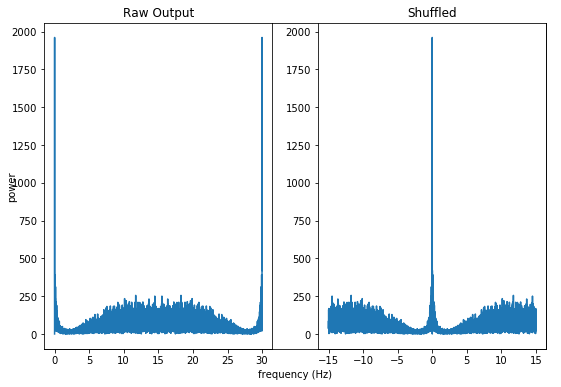

In [14]:
############## PLOTTING ############
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(freq_axis, ft)
ax2.plot(freq_axis_correct, ft_correct)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('power')
ax1.set_title('Raw Output')
ax2.set_title('Shuffled')
########################################

Now that we know what frequency components exist in the signal, we can design filters to attenuate any specific frequencies we do not want, or broadband noise in general. There are numerous filter options, and choosing one is usually a trade off between computation time, ripple in the stopband/passband, and the desire for recursive/nonrecursive methods. In this example, we will implement the commonly used Butterworth filter, which has a flat pass band and approaches ideal as the order is increased. If you would like more details on other filter options, the following is a great resource (although for MATLAB, analagous options exist in Python):

https://www.mathworks.com/help/signal/examples/practical-introduction-to-digital-filter-design.html

In [15]:
# Lets design a low pass filter to get our target frequency
# The cutoff must be mapped [0,1]; Tthe highest cutoff possible - fs/2 - is 1

def low_pass_filter(cutoff_low, sample_rate, order=3):
    low = cutoff_low/(0.5*sample_rate) 
    
    b, a = signal.butter(order, [low], btype='low')
    return b, a

low_cutoff = 5
b, a = low_pass_filter(low_cutoff, sample_rate, order=7)

w, h = signal.freqz(b, a) #frequency response of the filter
filter_freq_axis  = 1/(2*step_size*np.pi)*w
filter_response = abs(h)

filtered_signal_ff = signal.filtfilt(b, a, baseline_subtracted_ca) # *see note below

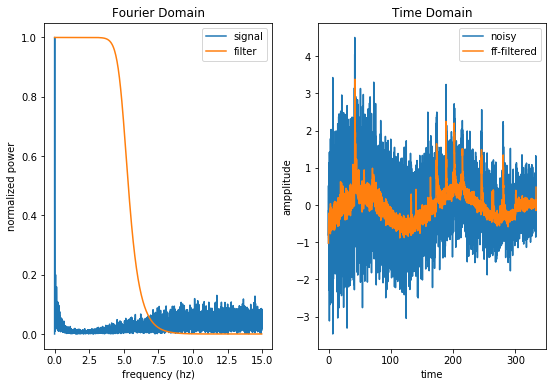

In [17]:
############## PLOTTING ###############
fig_image = plt.figure()
ax1 = fig_image.add_subplot(121)
ax2 = fig_image.add_subplot(122)

# lets just look at half of the signal, and normalize it
ax1.plot(freq_axis_correct[len(time_vec)/2:], ft_correct[len(time_vec)/2:]/ft_correct[len(time_vec)/2:].max())
# lets look at the filter's frequency response
ax1.plot(filter_freq_axis, filter_response)

ax2.plot(time_vec, baseline_subtracted_ca)
ax2.plot(time_vec, filtered_signal_ff) 

ax1.set_xlabel('frequency (hz)')
ax1.set_ylabel('normalized power')
ax1.set_title('Fourier Domain')
ax1.legend(['signal', 'filter'])
ax2.set_xlabel('time')
ax2.set_ylabel('ampplitude')
ax2.set_title('Time Domain')
ax2.legend(['noisy','ff-filtered'])
###########################################

** *NOTE: ** There are in fact two commonly used functions to filter you signal: `signal.lfilter` and `signal.filtfilt`. The former applies the filter once, and therefore introduces a phase shift, while the latter does both a forward and backward filter application to eliminate the phase shift (but increases computation time)

We saw in the above example what a filter looks like in the Fourier domain. In fact, the method of applying a filter differs in time and frequency. In the Fourier domain, we could imagine simply multiplying the signal and the filter, attenuating everything outside the passband, and retaining everything within the passband. This multiplication in frequency is actually a different operation -- convolution -- in time.  

** EXERCISE: FURTHER FILTER THE ABOVE SIGNAL**

In [18]:
############### EXERCISE ###############
# suggestions: implement a high pass filter to eliminate some low-frequency oscillations

<h2> Image Processing & 2D Filtering</h2>

Let's start by loading in the red and green channels of a two photon image, and convincing ourselves that images are really just matrices of pixel values. 

In [19]:
im_ch1 = ndi.imread('MAX_ZSeries-ch1.tif')
im_ch2 = ndi.imread('MAX_ZSeries-ch2.tif')
print im_ch1.shape, type(im_ch1), im_ch1.max(), im_ch1.min()

(512L, 512L) <type 'numpy.ndarray'> 4094 168


To create a colorful RGB image, we need to merge these two channels. To do that, let's create a numpy array full of zeros that has the same width and height as our channel arrays, but a depth of 3 (R, G, B). We can assign channel 1 (red) to the first stack, and channel 2 (green) to the second. Matplotlib has built in functions for displaying grayscale and rgb images.

In [20]:
# How to merge color channels
rgb_im = np.zeros((im_ch1.shape[0], im_ch1.shape[1], 3), 'float32')
rgb_im[...,0] = im_ch1
rgb_im[...,1] = im_ch2
rgb_im = rgb_im / rgb_im.max() #For RGB images, float values must be between 0-1; so we normalize to the max

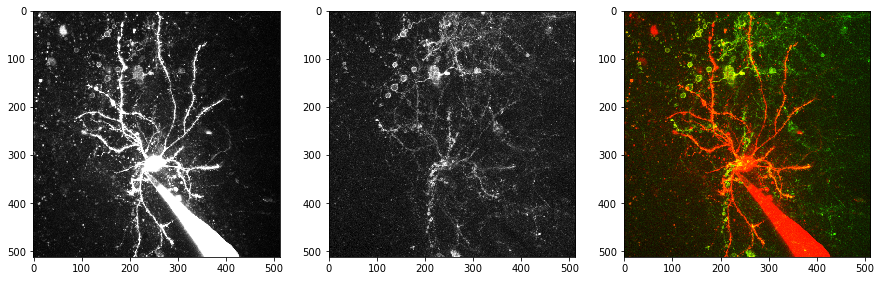

In [21]:
########## DISPLAY ###########
pylab.rcParams['figure.figsize'] = (15, 10) #enlarge figure size so images are easier to see

fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)

ax1.imshow(im_ch1, cmap=plt.cm.gray)
ax2.imshow(im_ch2, cmap=plt.cm.gray)
ax3.imshow(rgb_im) 

**2D Filtering**

Many of the same principles from filtering in 1D will also apply to 2D (image) filtering. A Gaussian filter will smooth the data in 2D (much like a running average), while a median filter will eliminate some salt-and-pepper noise while preserving the integrity of edges. 

In [22]:
cell_im = ndi.imread('BOb.png')[...,0] #load image

cell_smooth = ndi.gaussian_filter(cell_im, sigma=2) #gaussian filter
cell_median = ndi.median_filter(cell_im, size=5, mode='constant') #median filter

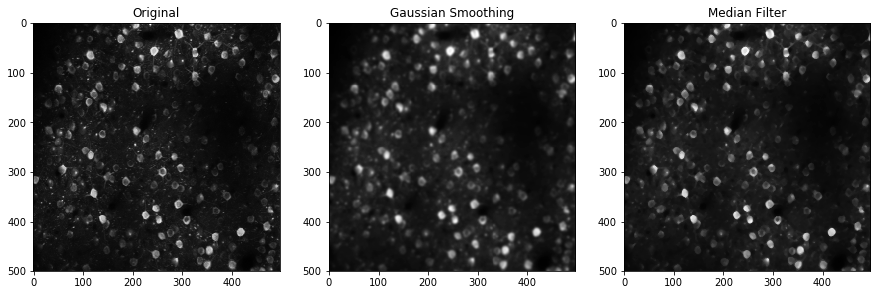

In [23]:
############### PLOTTING ################
fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)
ax1.imshow(cell_im, cmap=plt.cm.gray)
ax1.set_title('Original')
ax2.imshow(cell_smooth, cmap=plt.cm.gray)
ax2.set_title('Gaussian Smoothing')
ax3.imshow(cell_median, cmap=plt.cm.gray)
ax3.set_title('Median Filter')
##########################################

If our eventual goal is to find regions of interest corresponding to cells, one challenging factor may be the apparent difference in morphology between the cells in the images above. You will notice that some are filled (solid) while others appear to be rings. We can take advantage of a morphological operation, dilation, to essentially "fill" all rings. In dilation, each pixel value is replaced with the maximum pixel value of the region around it. This will act to both enlarge and fill the circle. The extent of this is determined by the size of the structuring element used for dilation. Although this operation will fill rings (good), it will artifically enlarge both cells and noise (bad). We can subsequently perform an erosion step with a structuring element of the same size. Erosion replaces each pixel with the minimum pixel value of its surroundings. Note that erosion is not quite the inverse of dilation: the rings that we filled will remain closed (they are surrounded by a neighborhood or bright pixels), but the size of the object will decrease. Both these operations can be done in ndimage with a single function: `grey_closing`

http://utam.gg.utah.edu/tomo03/03_mid/HTML/node119.html

In [24]:
# Let's use our median filtered image
closing_3 = ndi.morphology.grey_closing(cell_median, size=(3,3))
closing_10 = ndi.morphology.grey_closing(cell_median, size=(10,10))

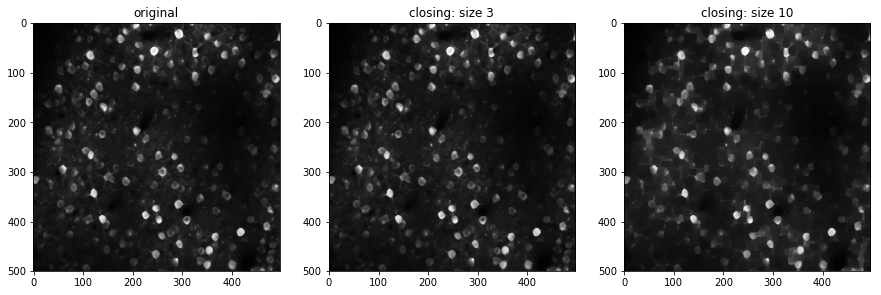

In [25]:
################# PLOTTING ##################
fig_image = plt.figure()
ax1 = fig_image.add_subplot(131)
ax2 = fig_image.add_subplot(132)
ax3 = fig_image.add_subplot(133)

ax1.imshow(cell_median, cmap=plt.cm.gray)
ax2.imshow(closing_3, cmap=plt.cm.gray)
ax3.imshow(closing_10, cmap=plt.cm.gray)

ax1.set_title('original')
ax2.set_title('closing: size 3')
ax3.set_title('closing: size 10')

<h2> Statistics </h2>

The `scipy.stats` module contains two major parts:

1. A set of classes representing [many continuous and discrete statistical distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) (gaussian, binomial, poisson, etc.)
2. A set of functions implementing [common statistical methods](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions) such as t-tests, ANOVA, correlation corfficients, etc.

---------------------

Let's begin by generating some random data. Scipy's distribution classes are designed such that each one implements the same basic interface (to the extent that this is possible). For example, we can generate random variables from any distribution by using its `rvs()` method:

In [26]:
import scipy.stats as stats
import numpy as np

# Pick 100 random values from a normal distribution centered at 5.0
dist1 = stats.norm(loc=5.0, scale=1.2)
data1 = dist1.rvs(size=100)

# Pick 100 random values from a lognormal distribution
dist2 = stats.lognorm(s=1, scale=3.2)
data2 = dist2.rvs(size=100)

# as a reminder, numpy already provides some very basic tools:
print "data1 mean: %f  stdev: %f" % (data1.mean(), data1.std())
print "data2 mean: %f  stdev: %f" % (data2.mean(), data2.std())

data1 mean: 5.031531  stdev: 1.200882
data2 mean: 5.104610  stdev: 5.303535


In [27]:
from matplotlib.pylab import axes
%matplotlib inline

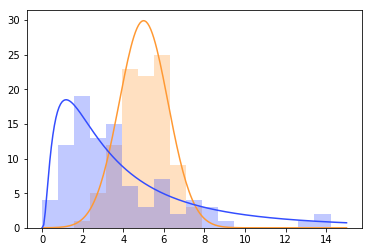

In [28]:
# plot histograms of the random values we generated
ax = axes()
bins = np.linspace(0, 15, 20)
ax.hist(data1, bins=bins, color=(1.0, 0.6, 0.2, 0.3));
ax.hist(data2, bins=bins, color=(0.2, 0.3, 1.0, 0.3));

# Use the pdf() method to plot the probability density function of each distribution
x = np.linspace(0, 15, 200)
ax.plot(x, dist1.pdf(x) * 90, color=(1, 0.6, 0.2));
ax.plot(x, dist2.pdf(x) * 90, color=(0.2, 0.3, 1.0));

We just saw uses of the `rvs()` and `pdf()` methods of continuous distributions. The full list of methods available for each distribution can be found at the bottom of its documentation page. Take a moment to look at the documentation for [scipy.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm) to get an idea of the methods available.

-----------------

Now let's try out a few of the functions available in scipy.stats. Start by having a peek at the [documentation](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions).

In [29]:
# Imagine data1 and data2 are repeated measurements taken under different conditions.
# It sure looks like the results are different, but our reviewer is asking for a p-value.
# How about a T-test?
stats.ttest_ind(data1, data2)

Ttest_indResult(statistic=-0.13371654225846588, pvalue=0.89376253471625999)

In [30]:
# Let's try a different approach..
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.45999999999999996, pvalue=5.6969068708337832e-10)

----------------
**Diversion:** some of the highest quality, vetted statistical tools are written in R. The `rpy2` module makes it possible to call R functions from the comfort of your Python environment.

In [31]:
# to run this code, you need the rpy2 package 
# (this can be installed by running `conda install rpy2`)
import rpy2.robjects.packages

ImportError: No module named rpy2.robjects.packages

In [11]:
# install Jewell & Witten's LZeroSpikeInference package (if needed)
import rpy2.robjects.packages as rpackages
if not rpackages.isinstalled('LZeroSpikeInference'):
    url = 'https://github.com/jewellsean/LZeroSpikeInference/archive/master.zip'
    print("Downloading %s..." % url)
    import urllib2
    response = urllib2.urlopen(url)
    open('LZeroSpikeInference.zip', 'w').write(response.read())
    
    print("Extracting zip...")
    import zipfile
    zip_ref = zipfile.ZipFile('LZeroSpikeInference.zip', 'r')
    zip_ref.extractall('LZeroSpikeInference')
    zip_ref.close()

    print("Installing package to R...")
    utils.install_packages("./LZeroSpikeInference/LZeroSpikeInference-master", repo=rpy2.robjects.NULL, type="source")
    
    print("Done!")

In [13]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
lzsi = rpy2.robjects.packages.importr("LZeroSpikeInference")

In [14]:
data = np.random.normal(loc=2, size=100)
fit = lzsi.estimateSpikes(data, **{'gam':0.8, 'lambda':1, 'type':"ar1"})

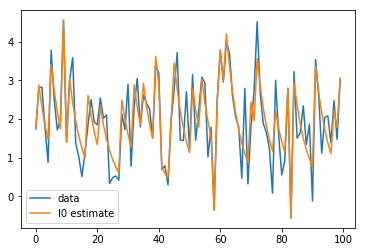

In [16]:
ax = axes()
ax.plot(data, label='data')
ax.plot(fit[1], label='l0 estimate')
ax.legend();

<h2> Additional Material & Exercises </h2>

** ELECTROPHYSIOLOGY TRACE ** 

(<matplotlib.text.Text at 0xf5de6a0>, <matplotlib.text.Text at 0xfb2f9e8>)

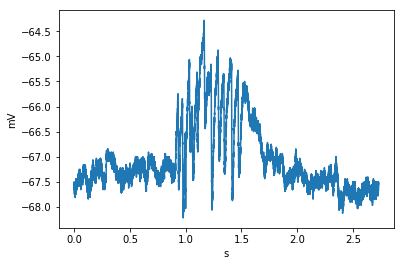

In [32]:
# Let's load up a slightly more complicated signal
# This trace has both synaptic events and background depolarization due to an optogenetic stimulation

with h5py.File('sweeps.h5', 'r') as f:
    electrode_2 = np.array(f['acquisition/timeseries/data_00000/electrode_2'])
    electrode_2_unit = f['acquisition/timeseries/data_00000/electrode_2'].attrs['unit']
    time = np.array(f['acquisition/timeseries/data_00000/time'])
    time_unit = f['acquisition/timeseries/data_00000/time'].attrs['unit']
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, electrode_2)
ax.set_xlabel(time_unit), ax.set_ylabel(electrode_2_unit) 

68250


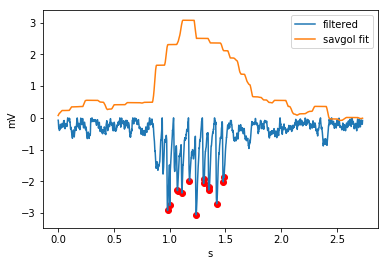

In [33]:
################ EXERCISE ###############
# Here are some tools

# take median of first 500 elements and subtract from trace
def zero_baseline(data):
    med = np.median(data[0:5000])
    return data - med

# filter: this function will function as a low, high, or band pass filter, but you will 
# most likely want to use it as a low pass filter for the signal above 
def filter_signal(data, sample_rate, cutoff_low = None, cutoff_high = None, order=5):
    if cutoff_low is not None:
        l = cutoff_low/(2*sample_rate)
        if cutoff_high is not None:
            filt_type = 'band'
            h = cutoff_high/(2*sample_rate)
            
            filts = [l, h]
        else:
            filt_type = 'low'
            filts = [l]
    elif cutoff_high is not None:
        filt_type = 'high'
        h = cutoff_high/(2*sample_rate)
        filts = [h]
    else:
        return 'Need some type of filter!'
    
    b, a = signal.butter(order, filts, btype = filt_type)
    
    filtered_data = signal.lfilter(b, a, data)
    
    return filtered_data
    

# sliding maximum filter to remove indirect depolarization
def sliding_max(data, win_len, smooth_win=500):
    max_filt = ndi.maximum_filter(data, win_len)
    smoothed = np.convolve(max_filt, np.ones(smooth_win)/smooth_win, mode='same')
    return smoothed
           

# peak detection, takes in optional threshold arguments
def find_peaks(data, pos_threshold = None, neg_threshold = None):
    
    if pos_threshold is None:
        pos_threshold = np.mean(data) + 2.5*np.std(data)
    if neg_threshold is None:
        neg_threshold = np.mean(data) - 2.5*np.std(data)
        
    sig_deriv = np.diff(data)
    
    sig_deriv = (sig_deriv > 0).astype(np.byte) 
    
    neg_peak_opts = np.argwhere(sig_deriv[1:] - sig_deriv[:-1] == 1) 
    pos_peak_opts = np.argwhere(sig_deriv[1:] - sig_deriv[:-1] == -1)
    
    pos = pos_peak_opts[data[pos_peak_opts] > pos_threshold]
    neg = neg_peak_opts[data[neg_peak_opts] < neg_threshold]
    
    return pos, neg


############# EXERCISE ###############
## use the above functions and suggestions below to play with various filtering options
## here is a start
sample_rate = 1/(time[1] - time[0])

zeroed = zero_baseline(electrode_2)
filtered = filter_signal(zeroed, sample_rate, cutoff_low = 1000)
win = 3000 #adjust this to change smoothing

max_filter = sliding_max(filtered, win)

print len(max_filter)
baseline_subtracted = filtered[0:len(max_filter)] - max_filter

pos, neg = find_peaks(baseline_subtracted)
####################################


#### plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time[0:len(baseline_subtracted)], baseline_subtracted)
ax.plot(time[0:len(max_filter)], max_filter)
ax.legend(['filtered', 'savgol fit'])
ax.scatter(time[neg], baseline_subtracted[neg], color='r')
ax.scatter(time[pos], baseline_subtracted[pos], color='g')
ax.set_xlabel('s')
ax.set_ylabel('mV')

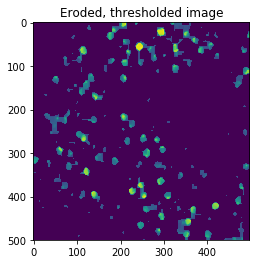

In [36]:
# Pick a threshold based on the above image. @Luke: do this in a more quantitiative way?

threshold_im = closing_10.copy()
threshold_im[closing_10< 50] = 0

fig_image = plt.figure()
ax = fig_image.add_subplot(111)
ax.imshow(threshold_im)
ax.set_title('Eroded, thresholded image')

The scikit-image packages contains several "blob detection" modules, and we will employ two of them here to attempt to classify cells in the above image:

1. Difference of Gaussians: this method involves the subtraction of two gaussian filters (similar to the ones employed earlier). This is analagous to passband in signal processing, and in an image, will extract the edges of an object. 

2. Laplacian of Gaussians: A gaussian filter first acts to smooth the image, and a Laplacian (which takes the second derivative, $L_{xx} + L_{yy} $) performs edge detection, but with a positive response moving into the blob, and a negative response moving out of the blob. 

Read more here:

http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog

http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log

http://fourier.eng.hmc.edu/e161/lectures/gradient/node9.html

http://fourier.eng.hmc.edu/e161/lectures/gradient/node8.html

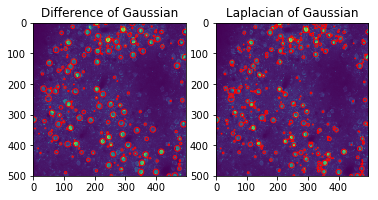

In [37]:
DoG = skimage.feature.blob_dog(threshold_im, max_sigma=10, threshold=0.005) 
LoG = skimage.feature.blob_log(threshold_im, max_sigma=10, threshold=0.01)
# play around with optional parameters, max_sigma & threshold, to alter the size/brightness
# of the blobs detected

fig_image = plt.figure()
ax1 = fig_image.add_subplot(121)
ax2 = fig_image.add_subplot(122)


ax1.imshow(cell_im) #back to our original images
ax2.imshow(cell_im)


for roi_DoG in DoG: 
    y_DoG = roi_DoG[0]
    x_DoG = roi_DoG[1]
    rad_DoG = roi_DoG[2] * sqrt(2)
    
    ##### EXERCISE ########
    
    # filter by size
    # if rad > threshold_pixels:
        # color = 'r'
        
    # else:
        # color = 'g'
        
    ax1.add_patch(plt.Circle((x_DoG,y_DoG), rad_DoG, color='r', fill=0))

for roi_LoG in LoG:
    y_LoG = roi_LoG[0]
    x_LoG = roi_LoG[1]
    rad_LoG = roi_LoG[2] * sqrt(2)
    
    ##### EXERCISE ########
    
    # filter by size
    # if rad > threshold_pixels:
        # color = 'r'
        
    # else:
        # continue
    
    
    ax2.add_patch(plt.Circle((x_LoG,y_LoG), rad_LoG, color='r', fill=0))


ax2.set_title('Laplacian of Gaussian')
ax1.set_title('Difference of Gaussian')